In [1]:
from probability import *
from utils import print_table, rounder
from notebook import psource, pseudocode, heatmap
from numpy import argmax

## HIDDEN MARKOV MODELS

Often, we need to carry out probabilistic inference on temporal data or a sequence of observations where the order of observations matter.
We require a model similar to a Bayesian Network, but one that grows over time to keep up with the latest evidences.
If you are familiar with the `mdp` module or Markov models in general, you can probably guess that a Markov model might come close to representing our problem accurately.
<br>
A Markov model is basically a chain-structured Bayesian Network in which there is one state for each time step and each node has an identical probability distribution.
The first node, however, has a different distribution, called the prior distribution which models the initial state of the process.
A state in a Markov model depends only on the previous state and the latest evidence and not on the states before it.
<br>
A **Hidden Markov Model** or **HMM** is a special case of a Markov model in which the state of the process is described by a single discrete random variable.
The possible values of the variable are the possible states of the world.
<br>
But what if we want to model a process with two or more state variables?
In that case, we can still fit the process into the HMM framework by redefining our state variables as a single "megavariable".
We do this because carrying out inference on HMMs have standard optimized algorithms.
A HMM is very similar to an MDP, but we don't have the option of taking actions like in MDPs, instead, the process carries on as new evidence appears.
<br>
If a HMM is truncated at a fixed length, it becomes a Bayesian network and general BN inference can be used on it to answer queries.

Before we start, it will be helpful to understand the structure of a temporal model. We will use the example of the book with the guard and the umbrella. In this example, the state $\textbf{X}$ is whether it is a rainy day (`X = True`) or not (`X = False`) at Day $\textbf{t}$. In the sensor or observation model, the observation or evidence $\textbf{U}$ is whether the professor holds an umbrella (`U = True`) or not (`U = False`) on **Day** $\textbf{t}$. Based on that, the transition model is 

| $X_{t-1}$         | $X_{t}$         | **P**$(X_{t}| X_{t-1})$|  
| -------------     |-------------    | ----------------------------------|
| ***${False}$***  | ***${False}$***  | 0.7                         |
| ***${False}$***  | ***${True}$***   | 0.3                         |
| ***${True}$***   | ***${False}$***  | 0.3                         |
| ***${True}$***   | ***${True}$***   | 0.7                         |

And the the sensor model will be,

| $X_{t}$          | $U_{t}$         | **P**$(U_{t}|X_{t})$|  
| :-------------:  |:-------------:  | :------------------------:|
| ***${False}$***  | ***${True}$***  | 0.2     |
| ***${False}$***  | ***${False}$*** | 0.8     |
| ***${True}$***   | ***${True}$***  | 0.9     |
| ***${True}$***   | ***${False}$*** | 0.1     |


HMMs are implemented in the **`HiddenMarkovModel`** class.
Let's have a look.

In [2]:
psource(HiddenMarkovModel)

We instantiate the object **`hmm`** of the class using a list of lists for both the transition and the sensor model.

In [3]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

The **`sensor_dist()`** method returns a list with the conditional probabilities of the sensor model.

In [4]:
hmm.sensor_dist(ev=True)

[0.9, 0.2]

Now that we have defined an HMM object, our task here is to compute the belief $B_{t}(x)= P(X_{t}|U_{1:t})$ given evidence **U** at each time step **t**.
<br>
The basic inference tasks that must be solved are:
1. **Filtering**: Computing the posterior probability distribution over the most recent state, given all the evidence up to the current time step.
2. **Prediction**: Computing the posterior probability distribution over the future state.
3. **Smoothing**: Computing the posterior probability distribution over a past state. Smoothing provides a better estimation as it incorporates more evidence.
4. **Most likely explanation**: Finding the most likely sequence of states for a given observation
5. **Learning**: The transition and sensor models can be learnt, if not yet known, just like in an information gathering agent
<br>
<br>

There are three primary methods to carry out inference in Hidden Markov Models:
1. The Forward-Backward algorithm
2. Fixed lag smoothing
3. Particle filtering

Let's have a look at how we can carry out inference and answer queries based on our umbrella HMM using these algorithms.

### FORWARD-BACKWARD
This is a general algorithm that works for all Markov models, not just HMMs.
In the filtering task (inference) we are given evidence **U** in each time **t** and we want to compute the belief $B_{t}(x)= P(X_{t}|U_{1:t})$. 
We can think of it as a three step process:
1. In every step we start with the current belief $P(X_{t}|e_{1:t})$
2. We update it for time
3. We update it for evidence

The forward algorithm performs the step 2 and 3 at once. It updates, or better say reweights, the initial belief using the transition and the sensor model. Let's see the umbrella example. On  **Day 0** no observation is available, and for that reason we will assume that we have equal possibilities to rain or not. In the **`HiddenMarkovModel`** class, the prior probabilities for **Day 0** are by default [0.5, 0.5]. 

The observation update is calculated with the **`forward()`** function. Basically, we update our belief using the observation model. The function returns a list with the probabilities of **raining or not** on **Day 1**.

In [5]:
psource(forward)

In [6]:
umbrella_prior = [0.5, 0.5]
belief_day_1 = forward(hmm, umbrella_prior, ev=True)
print ('The probability of raining on day 1 is {:.2f}'.format(belief_day_1[0]))

The probability of raining on day 1 is 0.82


In **Day 2** our initial belief is the updated belief of **Day 1**.
Again using the **`forward()`** function we can compute the probability of raining in **Day 2**

In [7]:
belief_day_2 = forward(hmm, belief_day_1, ev=True)
print ('The probability of raining in day 2 is {:.2f}'.format(belief_day_2[0]))

The probability of raining in day 2 is 0.88


In the smoothing part we are interested in computing the distribution over past states given evidence up to the present. Assume that we want to compute the distribution for the time **k**, for $0\leq k<t $, the computation can be divided in two parts: 
1. The forward message will be computed till and by filtering forward from 1 to **k**.
2. The backward message can be computed by a recusive process that runs from **k** to **t**. 

Rather than starting at time 1, the algorithm starts at time **t**. In the umbrella example, we can compute the backward message from **Day 2** to **Day 1** by using the `backward` function. The `backward` function has as parameters the object created by the **`HiddenMarkovModel`** class, the evidence in **Day 2** (in our case is **True**), and the initial probabilities of being in state in time t+1. Since no observation is available then it will be [1, 1]. The `backward` function will return a list with the conditional probabilities.

In [8]:
psource(backward)

In [9]:
b = [1, 1]
backward(hmm, b, ev=True)

[0.6272727272727272, 0.37272727272727274]

Some may notice that the result is not the same as in the book. The main reason is that in the book the normalization step is not used. If we want to normalize the result, one can use the **`normalize()`** helper function.

In order to find the smoothed estimate for raining in **Day k**, we will use the **`forward_backward()`** function. As in the example in the book, the umbrella is observed in both days and the prior distribution is [0.5, 0.5]

In [10]:
pseudocode('Forward-Backward')

### AIMA3e
__function__ FORWARD-BACKWARD(__ev__, _prior_) __returns__ a vector of probability distributions  
&emsp;__inputs__: __ev__, a vector of evidence values for steps 1,&hellip;,_t_  
&emsp;&emsp;&emsp;&emsp;&emsp;_prior_, the prior distribution on the initial state, __P__(__X__<sub>0</sub>)  
&emsp;__local variables__: __fv__, a vector of forward messages for steps 0,&hellip;,_t_    
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__b__, a representation of the backward message, initially all 1s  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__sv__, a vector of smoothed estimates for steps 1,&hellip;,_t_  

&emsp;__fv__\[0\] &larr; _prior_  
&emsp;__for__ _i_ = 1 __to__ _t_ __do__  
&emsp;&emsp;&emsp;__fv__\[_i_\] &larr; FORWARD(__fv__\[_i_ &minus; 1\], __ev__\[_i_\])  
&emsp;__for__ _i_ = _t_ __downto__ 1 __do__  
&emsp;&emsp;&emsp;__sv__\[_i_\] &larr; NORMALIZE(__fv__\[_i_\] &times; __b__)  
&emsp;&emsp;&emsp;__b__ &larr; BACKWARD(__b__, __ev__\[_i_\])  
&emsp;__return__ __sv__

---
__Figure ??__ The forward\-backward algorithm for smoothing: computing posterior probabilities of a sequence of states given a sequence of observations. The FORWARD and BACKWARD operators are defined by Equations (__??__) and (__??__), respectively.

In [11]:
hmm.prior = [0.5, 0.5]
prob = forward_backward(hmm, ev=[T, T])
print ('The probability of raining in Day 0 is {:.2f} and in Day 1 is {:.2f}'.format(prob[0][0], prob[1][0]))

The probability of raining in Day 0 is 0.65 and in Day 1 is 0.88



Since HMMs are represented as single variable systems, we can represent the transition model and sensor model as matrices.
The `forward_backward` algorithm can be easily carried out on this representation (as we have done here) with a time complexity of $O({S}^{2} t)$ where t is the length of the sequence and each step multiplies a vector of size $S$ with a matrix of dimensions $SxS$.
<br>
Additionally, the forward pass stores $t$ vectors of size $S$ which makes the auxiliary space requirement equivalent to $O(St)$.
<br>
<br>
Is there any way we can improve the time or space complexity?
<br>
Fortunately, the matrix representation of HMM properties allows us to do so.
<br>
If $f$ and $b$ represent the forward and backward messages respectively, we can modify the smoothing algorithm by first
running the standard forward pass to compute $f_{t:t}$ (forgetting all the intermediate results) and then running
backward pass for both $b$ and $f$ together, using them to compute the smoothed estimate at each step.
This optimization reduces auxlilary space requirement to constant (irrespective of the length of the sequence) provided
the transition matrix is invertible and the sensor model has no zeros (which is sometimes hard to accomplish)
<br>
<br>
Let's look at another algorithm, that carries out smoothing in a more optimized way.

### FIXED LAG SMOOTHING
The matrix formulation allows to optimize online smoothing with a fixed lag.
<br>
Since smoothing can be done in constant, there should exist an algorithm whose time complexity is independent of the length of the lag.
For smoothing a time slice $t - d$ where $d$ is the lag, we need to compute $\alpha f_{1:t-d}$ x $b_{t-d+1:t}$ incrementally.
<br>
As we already know, the forward equation is
<br>
$$f_{1:t+1} = \alpha O_{t+1}{T}^{T}f_{1:t}$$
<br>
and the backward equation is
<br>
$$b_{k+1:t} = TO_{k+1}b_{k+2:t}$$
<br>
where $T$ and $O$ are the transition and sensor models respectively.
<br>
For smoothing, the forward message is easy to compute but there exists no simple relation between the backward message of this time step and the one at the previous time step,  hence we apply the backward equation $d$ times to get
<br>
$$b_{t-d+1:t} = \left ( \prod_{i=t-d+1}^{t}{TO_i} \right )b_{t+1:t} = B_{t-d+1:t}1$$
<br>
where $B_{t-d+1:t}$ is the product of the sequence of $T$ and $O$ matrices.
<br>
Here's how the `probability` module implements `fixed_lag_smoothing`.
<br>

In [12]:
psource(fixed_lag_smoothing)

This algorithm applies `forward` as usual and optimizes the smoothing step by using the equations above.
This optimization could be achieved only because HMM properties can be represented as matrices.
<br>
`vector_to_diagonal`, `matrix_multiplication` and `inverse_matrix` are matrix manipulation functions to simplify the implementation.
<br>
`normalize` is used to normalize the output before returning it.

Here's how we can use `fixed_lag_smoothing` for inference on our umbrella HMM.

In [13]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

Given evidence T, F, T, F and T, we want to calculate the probability distribution for the fourth day with a fixed lag of 2 days.
<br>
Let `e_t = False`

In [14]:
e_t = F
evidence = [T, F, T, F, T]
fixed_lag_smoothing(e_t, hmm, d=2, ev=evidence, t=4)

[0.1111111111111111, 0.8888888888888888]

In [15]:
e_t = T
evidence = [T, T, F, T, T]
fixed_lag_smoothing(e_t, hmm, d=1, ev=evidence, t=4)

[0.9938650306748466, 0.006134969325153394]

We cannot calculate probability distributions when $t$ is less than $d$

In [16]:
fixed_lag_smoothing(e_t, hmm, d=5, ev=evidence, t=4)

As expected, the output is `None`

### Viterbi Algorithm

With the viterbi algorithm, we compute incrementally the most likely sequence of states:

$$\mu(e_{t+1}) = \max_{x_1\ldots x_t} \mathbf{P}(x_1,\ldots,x_t,X_{t+1} | e_{1:t+1}) $$
$$ = \alpha \mathbf{P}(e_{t+1} | X_{t+1}) \max_{x_t}\left(\mathbf{P}(X_{t+1} | x_t) \max_{x_1\ldots x_{t-1}} P(x_1,\ldots,x_{t-1},x_t |e_{1:t}) \right). $$


In [17]:
psource(viterbi)

In [18]:
# transistion model
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]

# sensor model
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]

# HMM
umbrellaHMM = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

evidence = [T, F, T, F, T]
sequence, m = viterbi(umbrellaHMM, evidence)

# most likely sequence extracted by backtracking 
print('\nMost likely sequence:')
print(rounder(sequence))

#computed values
print('Computed mu(e_t) of the most likely sequence for each time step:')
print(m)
    


Most likely sequence:
[1, 0, 0, 0, 1]
Computed mu(e_t) of the most likely sequence for each time step:
[0.8181818181818181, 0.19636363636363635, 0.02749090909090909, 0.015394909090909091, 0.004156625454545455]


### PARTICLE FILTERING
The filtering problem is too expensive to solve using the previous methods for problems with large or continuous state spaces.
Particle filtering is a method that can solve the same problem but when the state space is a lot larger, where we wouldn't be able to do these computations in a reasonable amount of time as fast, as time goes by, and we want to keep track of things as they happen.
<br>
The downside is that it is a sampling method and hence isn't accurate, but the more samples we're willing to take, the more accurate we'd get.
<br>
In this method, instead of keping track of the probability distribution, we will drop particles in a similar proportion at the required regions.
The internal representation of this distribution is usually a list of particles with coordinates in the state-space.
A particle is just a new name for a sample.

Particle filtering can be divided into four steps:
1. __Initialization__: 
If we have some idea about the prior probability distribution, we drop the initial particles accordingly, or else we just drop them uniformly over the state space.

2. __Forward pass__: 
As time goes by and measurements come in, we are going to move the selected particles into the grid squares that makes the most sense in terms of representing the distribution that we are trying to track.
When time goes by, we just loop through all our particles and try to simulate what could happen to each one of them by sampling its next position from the transition model.
This is like prior sampling - samples' frequencies reflect the transition probabilities.
If we have enough samples we are pretty close to exact values.
We work through the list of particles, one particle at a time, all we do is stochastically simulate what the outcome might be.
If we had no dimension of time, and we had no new measurements come in, this would be exactly the same as what we did in prior sampling.

3. __Reweight__:
As observations come in, don't sample the observations, fix them and downweight the samples based on the evidence just like in likelihood weighting.
$$w(x) = P(e/x)$$
$$B(X) \propto P(e/X)B'(X)$$
<br>
As before, the probabilities don't sum to one, since most have been downweighted.
They sum to an approximation of $P(e)$.
To normalize the resulting distribution, we can divide by $P(e)$
<br>
Likelihood weighting wasn't the best thing for Bayesian networks, because we were not accounting for the incoming evidence so we were getting samples from the prior distribution, in some sense not the right distribution, so we might end up with a lot of particles with low weights. 
These samples were very uninformative and the way we fixed it then was by using __Gibbs sampling__.
Theoretically, Gibbs sampling can be run on a HMM, but as we iterated over the process infinitely many times in a Bayesian network, we cannot do that here as we have new incoming evidence and we also need computational cycles to propagate through time.
<br>
A lot of samples with very low weight and they are not representative of the _actual probability distribution_.
So if we keep running likelihood weighting, we keep propagating the samples with smaller weights and carry out computations for that even though these samples have no significant contribution to the actual probability distribution.
Which is why we require this last step.

4. __Resample__:
Rather than tracking weighted samples, we _resample_.
We choose from our weighted sample distribution as many times as the number of particles we initially had and we replace these particles too, so that we have a constant number of particles.
This is equivalent to renormalizing the distribution.
The samples with low weight are rarely chosen in the new distribution after resampling.
This newer set of particles after resampling is in some sense more representative of the actual distribution and so we are better allocating our computational cycles.
Now the update is complete for this time step, continue with the next one.

<br>
Let's see how this is implemented in the module.

In [19]:
psource(particle_filtering)

Here, `scalar_vector_product` and `vector_add` are helper functions to help with vector math and `weighted_sample_with_replacement` resamples from a weighted sample and replaces the original sample, as is obvious from the name.
<br>
This implementation considers two state variables with generic names 'A' and 'B'.


Here's how we can use `particle_filtering` on our umbrella HMM, though it doesn't make much sense using particle filtering on a problem with such a small state space.
It is just to get familiar with the syntax.

In [20]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

In [21]:
particle_filtering(T, 10, hmm)

['B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A']

We got 5 samples from state `A` and 5 samples from state `B`

In [22]:
particle_filtering([F, T, F, F, T], 10, hmm)

['B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B']

This time we got 2 samples from state `A` and 8 samples from state `B`

Comparing runtimes for these algorithms will not be useful, as each solves the filtering task efficiently for a different scenario.
<br>
`forward_backward` calculates the exact probability distribution.
<br>
`fixed_lag_smoothing` calculates an approximate distribution and its runtime will depend on the value of the lag chosen.
<br>
`particle_filtering` is an efficient method for approximating distributions for a very large or continuous state space.

## MONTE CARLO LOCALIZATION
In the domain of robotics, particle filtering is used for _robot localization_.
__Localization__ is the problem of finding out where things are, in this case, we want to find the position of a robot in a continuous state space.
<br>
__Monte Carlo Localization__ is an algorithm for robots to _localize_ using a _particle filter_.
Given a map of the environment, the algorithm estimates the position and orientation of a robot as it moves and senses the environment.
<br>
Initially, particles are distributed uniformly over the state space, ie the robot has no information of where it is and assumes it is equally likely to be at any point in space.
<br>
When the robot moves, it analyses the incoming evidence to shift and change the probability to better approximate the probability distribution of its position.
The particles are then resampled based on their weights.
<br>
Gradually, as more evidence comes in, the robot gets better at approximating its location and the particles converge towards the actual position of the robot.
<br>
The pose of a robot is defined by its two Cartesian coordinates with values $x$ and $y$ and its direction with value $\theta$.
We use the kinematic equations of motion to model a deterministic state prediction.
This is our motion model (or transition model).
<br>
Next, we need a sensor model.
There can be two kinds of sensor models, the first assumes that the sensors detect _stable_, _recognizable_ features of the environment called __landmarks__.
The robot senses the location and bearing of each landmark and updates its belief according to that.
We can also assume the noise in measurements to be Gaussian, to simplify things.
<br>
Another kind of sensor model is used for an array of range sensors, each of which has a fixed bearing relative to the robot.
These sensors provide a set of range values in each direction.
This will also be corrupted by Gaussian noise, but we can assume that the errors for different beam directions are independent and identically distributed.
<br>
After evidence comes in, the robot updates its belief state and reweights the particle distribution to better aproximate the actual distribution.
<br>
<br>
Let's have a look at how this algorithm is implemented in the module

In [23]:
psource(monte_carlo_localization)

Our implementation of Monte Carlo Localization uses the range scan method.
The `ray_cast` helper function casts rays in different directions and stores the range values.
<br>
`a` stores the `v` and `w` components of the robot's velocity.
<br>
`z` is a range scan.
<br>
`P_motion_sample` is the motion or transition model.
<br>
`P_sensor` is the range sensor noise model.
<br>
`m` is the 2D map of the environment
<br>
`S` is a vector of samples of size N

We'll now define a simple 2D map to run Monte Carlo Localization on.
<br>
Let's say this is the map we want
<br>

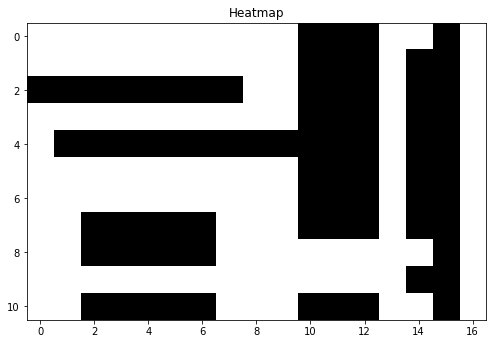

In [24]:
m = MCLmap([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]])

heatmap(m.m, cmap='binary')

Let's define the motion model as a function `P_motion_sample`.

In [25]:
def P_motion_sample(kin_state, v, w):
    """Sample from possible kinematic states.
    Returns from a single element distribution (no uncertainity in motion)"""
    pos = kin_state[:2]
    orient = kin_state[2]

    # for simplicity the robot first rotates and then moves
    orient = (orient + w)%4
    for _ in range(orient):
        v = (v[1], -v[0])
    pos = vector_add(pos, v)
    return pos + (orient,)

Define the sensor model as a function `P_sensor`.

In [26]:
def P_sensor(x, y):
    """Conditional probability for sensor reading"""
    # Need not be exact probability. Can use a scaled value.
    if x == y:
        return 0.8
    elif abs(x - y) <= 2:
        return 0.05
    else:
        return 0

Initializing variables.

In [27]:
a = {'v': (0, 0), 'w': 0}
z = (2, 4, 1, 6)

Let's run `monte_carlo_localization` with these parameters to find a sample distribution S.

In [28]:
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m)

Let's plot the values in the sample distribution `S`.

GRID:
 0    0   11   165   176    4    0   0   0   0   0   0   0   0   0   0   0
 0    0    0     0    13   78   44   6   0   0   0   0   0   0   0   0   0
 0    0    0     0     0    0    0   0   0   0   0   0   0   0   0   0   0
 0    0    2     0     5   11    9   0   0   0   0   0   0   0   0   0   0
 0    0    0     0     0    0    0   0   0   0   0   0   0   0   0   0   0
 0    0   10    71   145    7    0   0   0   0   0   0   0   0   0   0   0
 0    0    0     0     7   80   39   0   0   0   0   0   0   0   0   0   0
42   13    0     0     0    0    0   0   0   1   0   0   0   0   0   0   0
32    0    0     0     0    0    0   0   0   0   0   0   0   0   0   0   0
 0    0    0     6     3   20    0   0   0   0   0   0   0   0   0   0   0
 0    0    0     0     0    0    0   0   0   0   0   0   0   0   0   0   0


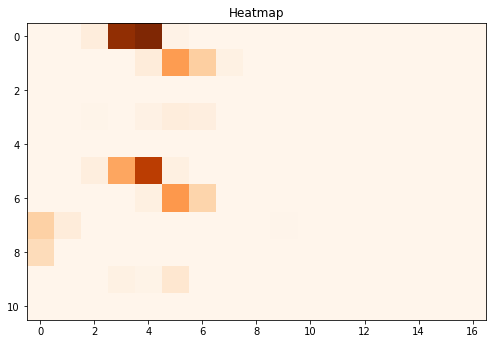

In [29]:
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

The distribution is highly concentrated at `(5, 3)`, but the robot is not very confident about its position as some other cells also have high probability values.

Let's look at another scenario.

GRID:
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   1000   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0


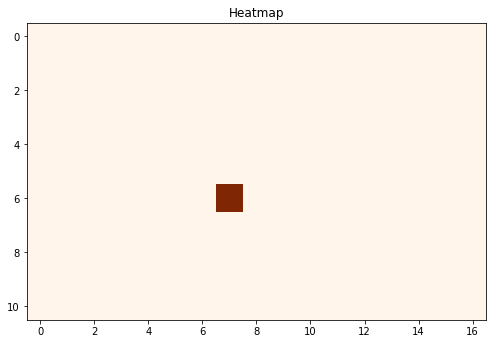

In [30]:
a = {'v': (0, 1), 'w': 0}
z = (2, 3, 5, 7)
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m, S)
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

In this case, the robot is 99.9% certain that it is at position `(6, 7)`.
